# Practical Session: Q-Learning

In this practical session, you will implement the famous [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf) algorithm and test it in various environments.

# OpenAI Gym

The [Gym library](https://www.google.com/search?client=firefox-b-d&q=openai+gym)  is a collection of test problems (or environments) developed by [OpenAI](https://openai.com/) sharing a standard interface.
This standard interface allows us to write general reinforcement learning algorithms and test them on several environments without many adaptations.

Gym's interface is very simple. 
Its core object is an **environment**, usually instancied with the instruction 
```python
gym.make("ENV_NAME")
```
A gym environment has three key methods:
* `reset()`: this method reset the environment and return an observation of a random initial state 
* `step(a)`: this method takes an action `a` and returns three variable:
    * `observation`: the observation of the next state
    * `reward`: the reward obtained after transitioning from the previous state to the new one taking action `a`
    * `done`: a boolean indicating if an episode is finished
    * `info`: a variable used to pass any other kind of information
* `render()` this method renders the current state of the environment

## Taxi V3

The taxi problem was first introduced in [Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition](https://arxiv.org/abs/cs/9905014).  
In this environment the agent controls a taxi whose job is to pick up a passenger at one location and drop him off in his target location.  

Dropping of the passenger to its destination leads to a `+20` reward.  
To encourage the agent to be as fast as possible, it recieves a deceptive reward of `-1` at ech step.  
It will also receive a `-10` penality reward if it takes an illegal 'pick-up' or drop-off' action.  

Let's instanciate a Taxi-V3 environment:

In [6]:
import gym
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The taxi is represented in <span style="color:yellow">yellow</span> when empty and in <span style="color:green">green</span> when full.  
The passenger is represented in <span style="color:blue">blue</span> and his destination in <span style="color:magenta">magenta</span>.

Observations: There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

In [7]:
print(f"State Space {env.observation_space}")

State Space Discrete(500)


The agent controling the *taxi* has 6 discrete and deterministic possibles actions:  
*  0: *move south*
*  1: *move north*
*  2: *move east*
*  3: *move west*
*  4: *pickup passenger*
*  5: *drop off passenger*  

In [8]:
print(f"Action Space {env.action_space}")

Action Space Discrete(6)


This is a little method to vizualize our taxi's trips:

In [9]:
from IPython.display import clear_output
from time import sleep

def display_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Reward: {frame['reward']}")
        sleep(.2)

# Random agent

The following code shows you how to run an episode with an agent taking random actions

In [14]:
frames = [] # for animation

env.reset()
while True:
    # draw a random action from the action space
    action = env.action_space.sample()
    # the step method takes an action as input and returns 4 variables described in the OpenAI section
    state, reward, done, info = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        })
    #if done is True then the episode is over
    if done == True:
        break
        
display_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 200
State: 332
Reward: -10


## Human policy 

In [18]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



We just saw a random policy, lets now check on your own policy.  
Using the possible actions, make a little script to take the client to his destination and visualize it with the `display_frames` method

In [19]:
frames = [] 
actions = [3,3,0,3,3,1,1,4,0,0,2,2,2,0,0,5]
for a in actions:
    state, reward, _, _ = env.step(a)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        })

display_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 16
State: 475
Reward: 20


# RL

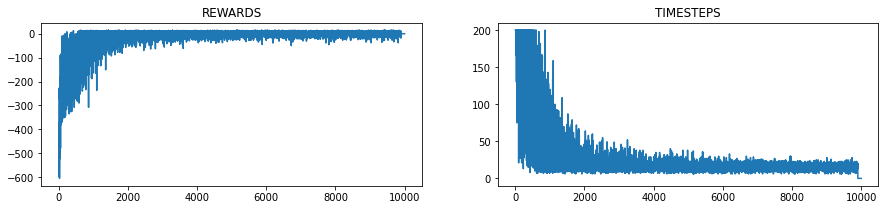

Episode: 9900
Training finished.



In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.1
gamma = 0.6
epsilon = 0.1

nb_episodes = 10000

q_table = np.zeros([env.observation_space.n, env.action_space.n])
training_stats={'timesteps':np.zeros(nb_episodes), 
                'rewards': np.zeros(nb_episodes)}
for i in range(nb_episodes):
    state = env.reset()
    timesteps, total_rewards, = 0, 0
    while True:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        training_stats['rewards'][i] += reward
        training_stats['timesteps'][i] += 1
        state = next_state
        
        if done:
            break
        
     
        
    if i % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(15,3))
        plt.subplot(1,2,1)
        plt.plot(training_stats['rewards'])
        plt.title("REWARDS")
        plt.subplot(1,2,2)
        plt.plot(training_stats['timesteps'])
        plt.title("TIMESTEPS")
        plt.show()
        print(f"Episode: {i}")

print("Training finished.\n")


In [8]:
env.reset()
frames = [] # for animation
timesteps = 0
while True:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'reward': reward
        }
    )

    timesteps += 1
    if done:
        break
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 13
State: 0
Reward: 20


# Parameters tunning with optuna

# Try with frozen lake

In [31]:
import gym
env = gym.make("FrozenLake8x8-v0").env
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
